In [1]:
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import lil_matrix
from scipy.spatial.distance import euclidean

In [17]:
 def diGraph_from_dem(dem_path,cell_size=1.0):
     
    """
    Builds a directed graph from a LiDAR-derived DEM (TIFF)
    
    Args: 
        dem_path (str): Path to the DEM TIFF file
        cell_size (float): size of DEM cell
        connectivity (int): assumes 8 - cardinals plus diagonals
    
    Returns:
        graph (nx.DiGraph): a directed graph such that each node
            corresponds to a dem cell from the raster with:
            - node attributes:
                - elev (float): the elevation of the cell
                - isPit (boolean): marking cell as pit (no outlet)
                - isSource (boolean): marking as source (no inlet)
                - node_idx (int, int): indices of the node on the dem tile
            - edge attributes:
                - weight (float): absolute value of slope between two nodes
    
    Terms:
        pit - node with no neighbors lower than itself and at least one higher
        source - node with no neighbors lower than itself and at least one lower
    
    """

    with rasterio.open(dem_path) as src:
        dem_data = src.read(1)
        height, width = dem_data.shape
    
    num_nodes = height*width
    graph = nx.DiGraph()
    # node_indices = {} # location on the tiff tile

    # track pit and source nodes
    pitList = []
    sourceList = []
    
    # assuming cardinal and diagonal neighbors
    neighbors = [(-1,0), (1,0), (0,1), (0,-1),
                 (-1,-1), (-1,1), (1,-1), (1,1)]
    
    
    
    for r in range(height):
        for c in range(width):
            current_node_idx = r * width + c # iterates through num_nodes
            # Add node with attributes
            graph.add_node(current_node_idx, 
                           dem_idx=[r,c], 
                           elev=dem_data[r,c],
                           is_pit=False,
                           is_source=False)

            minSlope = 0
            maxSlope = 0
            next_node = current_node_idx
            
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
    
                if 0 <= nr < height and 0 <= nc < width: # check nr, nc in bounds
                    neighbor_node_idx = nr*width + nc # index in lil_matrix
                    
                    # neigbor - center: negative implies downslope from center
                    slope = dem_data[nr,nc] - dem_data[r,c]
                    slope = slope / (np.linalg.norm([dr,dc])*cell_size) # normalize
                    
                    if slope < minSlope:
                        minSlope = slope
                        next_node = neighbor_node_idx
                    elif slope > maxSlope:
                        maxSlope = slope
                        
            
            #after looping through neighbors of r,c
            if minSlope < 0:
                wgt = abs(minSlope)
                graph.add_edge(current_node_idx, next_node, weight=wgt)
                if maxSlope == 0: # outflow + no inflow = source
                    graph.nodes[current_node_idx]["is_source"] = True
                    sourceList.append(current_node_idx)
            elif minSlope == 0: # no outlets
                if maxSlope > 0: # only a pit if you have inflow
                    graph.nodes[current_node_idx]["is_pit"] = True
                    pitList.append(current_node_idx)

        

                    
    
                    
    print("pit count: " + str(len(pitList)))
    print("sourceList: " + str(len(sourceList)))
    return graph, pitList, sourceList, dem_data

In [18]:
# r convert normal string to raw string
dem_file = "smallBluff1.tif"

In [19]:
wolfGraph, pitList, sourceList, dem_data = diGraph_from_dem(dem_file)

pit count: 1060
sourceList: 1219


In [41]:
#  flow path from a single source
def trace_proper_flow_path(graph, start_node):
    """
    Traces the flow path from a source node until it reaches a pit or dead end.
    
    Returns:
        path (list): List of node indices in the flow path
    """
    # source must be valid
    elev = graph.nodes[start_node]["elev"]
    if elev < 0:
        return

        
    path = [start_node]
    current = start_node
   

    while graph.out_degree(current) > 0 and elev >=0:  # While there's an outflow
        next_node = list(graph.successors(current))[0]  # Get the single downstream node
        path.append(next_node)
        elev = graph.nodes[next_node]["elev"]
        current = next_node
        
        # Safety check for cycles (shouldn't happen in proper flow graph)
        # if len(path) > height * width:
           # print("Warning: Cycle detected!")
           # break
    
    return path

In [43]:
# list of "proper" flows
properPathsList = []
for s in sourceList:
    path = trace_proper_flow_path(wolfGraph, s)
    properPathsList.append(path)

print(f"number of proper paths: {len(properPathsList)}")

number of proper paths: 1219


Flow path length: 74 nodes
Starts at elevation: 11.23m
Ends at elevation: 0.07m


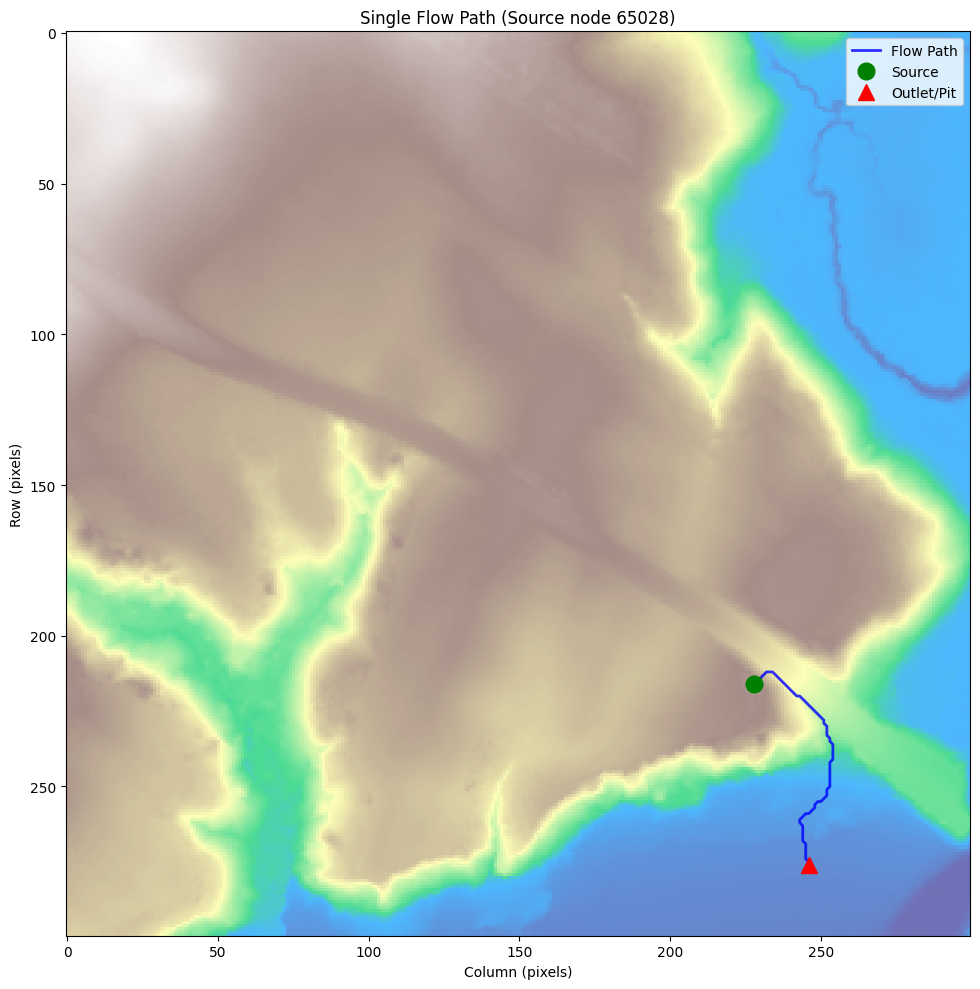

In [39]:
# Get the first source and trace its path
start_source = sourceList[902]
flow_path = trace_flow_path(wolfGraph, start_source)

print(f"Flow path length: {len(flow_path)} nodes")
print(f"Starts at elevation: {wolfGraph.nodes[flow_path[0]]['elev']:.2f}m")
print(f"Ends at elevation: {wolfGraph.nodes[flow_path[-1]]['elev']:.2f}m")

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Hillshade background
ax.imshow(dem_data, cmap='terrain', alpha=0.7)

# Draw the flow path as connected line segments
path_coords = []
for node in flow_path:
    r, c = wolfGraph.nodes[node]['dem_idx']
    path_coords.append([c, r])  # Note: matplotlib uses (x, y) = (col, row)

path_coords = np.array(path_coords)
ax.plot(path_coords[:, 0], path_coords[:, 1], 
        'b-', linewidth=2, alpha=0.8, label='Flow Path')

# Mark start (source) and end (pit or outlet)
start_r, start_c = wolfGraph.nodes[flow_path[0]]['dem_idx']
end_r, end_c = wolfGraph.nodes[flow_path[-1]]['dem_idx']

ax.plot(start_c, start_r, 'go', markersize=12, label='Source', zorder=5)
ax.plot(end_c, end_r, 'r^', markersize=12, label='Outlet/Pit', zorder=5)
'''
# Add some intermediate points for reference
if len(flow_path) > 4:
    for i in [len(flow_path)//4, len(flow_path)//2, 3*len(flow_path)//4]:
        r, c = wolfGraph.nodes[flow_path[i]]['dem_idx']
        ax.plot(c, r, 'yo', markersize=6, alpha=0.7)
'''
ax.legend()
# ax.set_title(f"Single Flow Path (Source node {start_source})")
ax.set_xlabel("Column (pixels)")
ax.set_ylabel("Row (pixels)")
plt.tight_layout()
plt.show()

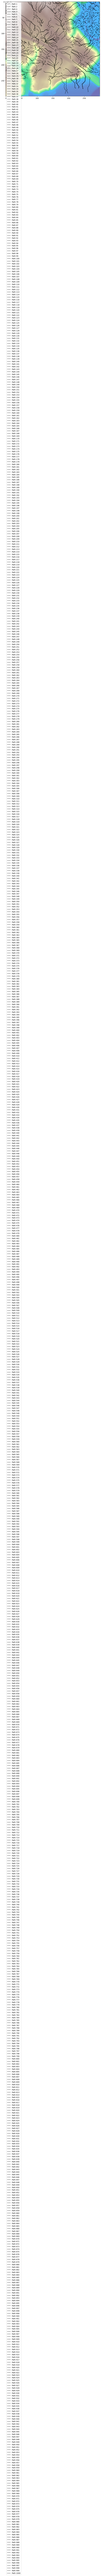

In [64]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(dem_data, cmap='terrain', alpha=0.7)


# Plot first 5 sources
for i, source in enumerate(sourceList[:1000]):
    path = trace_flow_path(wolfGraph, source)
    path_coords = np.array([[wolfGraph.nodes[n]['dem_idx'][1], 
                             wolfGraph.nodes[n]['dem_idx'][0]] for n in path])
    ax.plot(path_coords[:, 0], path_coords[:, 1], color='k',
            linewidth=1.5, alpha=0.7, label=f'Path {i+1}')

ax.legend()
plt.show()